# Problem Description

The assignment involves an FPSO (Floating Production, Storage and Offloading) vessel data. The vessel contains some equipment and each equipment have multiple sensors. Every time a failure happens, we get all the sensors data from the failed equipment and we store this information in a log file, the time is in GMT time zone.

 

You are provided 3 files: the log file named equipment_failure_sensors.log; the file named equipment_sensors.csv with the relationships between sensors and equipment and the file named equipment.json with the equipment data.

 

To solve this problem, we expect you to answer a few questions related to January 2020 considering GMT time zone:

1 – Total equipment failures that happened?

2 – Which equipment code had most failures?

3 – Average amount of failures across equipment group, ordering by the amount of failures in ascending order?

Feel free to use the programming language and tools (cloud, SQL databases, ...) you would like. Once you’re done, please send us a zip file containing all your code and a document explaining the steps that were taken with the responses for the questions, but also other conclusions and insights that you think are relevant to the project. We value creativity!

If the zip file is bigger than the attachment limit, please upload the zip file in a file sharing service (Google Drive, Dropbox, WeTransfer, ...) and send us the link.

Thank you for your time and we hope you have fun!

## Relevant Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

## Load Data

In [2]:
df_failure_log = pd.read_csv("equipment_failure_sensors.log", delimiter="\t", names=["dateTime","error",
                                                                                     "sensor_id","temperature",
                                                          "TEMPERATURE","VIBRATION"],header=None)

In [3]:
df_failure_log.head()

,dateTime,error,sensor_id,temperature,TEMPERATURE,VIBRATION
0,[2019-12-10 10:46:09],ERROR,sensor[5]:,(temperature,"365.26, vibration",-6305.32)
1,[2019-12-10 10:46:09],ERROR,sensor[43]:,(temperature,"458.47, vibration",-58.41)
2,[2019-12-10 10:46:09],ERROR,sensor[44]:,(temperature,"57.16, vibration",-999.66)
3,[2019-12-10 10:46:09],ERROR,sensor[67]:,(temperature,"106.69, vibration",-4659.02)
4,[2019-12-02 06:53:29],ERROR,sensor[5]:,(temperature,"26.42, vibration",-3438.67)


## Preprocessing

#### Remove all non-numeric characters with regular expressions (regex)

In [4]:
df_failure_log["sensor_id"] = df_failure_log["sensor_id"].str.extract('(\d+)', expand=False)

In [5]:
df_failure_log["TEMPERATURE"] = df_failure_log["TEMPERATURE"].str.extract('([-+]?\d+\.\d+)', expand=False)

In [6]:
df_failure_log["VIBRATION"] = df_failure_log["VIBRATION"].str.extract('([-+]?\d+\.\d+)', expand=False)

In [7]:
df_failure_log["DATE"] = df_failure_log["dateTime"].str.extract("(\d{4}-\d{2}-\d{2})", expand=False)

In [8]:
df_failure_log["TIME"] = df_failure_log["dateTime"].str.extract("(\d{2}:\d{2}:\d{2})", expand=False)

#### Drop unnecessary columns

In [9]:
df_failure_log = df_failure_log.drop(columns=["dateTime","error","temperature"], axis=1)

#### Reorder columns

In [10]:
df_failure_log = df_failure_log[["DATE","TIME","sensor_id","TEMPERATURE","VIBRATION"]]

#### Change column data type

In [11]:
df_failure_log.dtypes

DATE           object
TIME           object
sensor_id      object
TEMPERATURE    object
VIBRATION      object
dtype: object

In [12]:
df_failure_log[["TEMPERATURE","VIBRATION"]] = df_failure_log[["TEMPERATURE","VIBRATION"]].apply(pd.to_numeric)

df_failure_log["DATE"] = pd.to_datetime(df_failure_log["DATE"])

df_failure_log["TIME"] = pd.to_timedelta(df_failure_log["TIME"])

df_failure_log.dtypes

DATE            datetime64[ns]
TIME           timedelta64[ns]
sensor_id               object
TEMPERATURE            float64
VIBRATION              float64
dtype: object

### SavePoint & Basic Descriptive Statistics

In [13]:
df_failure_log_prep = df_failure_log

In [14]:
df_failure_log_prep.describe(include="all")

<ipython-input-14-9dac379943e1>:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  df_failure_log_prep.describe(include="all")


,DATE,TIME,sensor_id,TEMPERATURE,VIBRATION
count,36979,36979,36979,36979.000000,36979.000000
unique,101,NaN,96,NaN,NaN
top,2020-01-13 00:00:00,NaN,38,NaN,NaN
freq,469,NaN,417,NaN,NaN
first,2019-12-01 00:00:00,NaN,NaN,NaN,NaN
last,2020-03-10 00:00:00,NaN,NaN,NaN,NaN
mean,NaN,0 days 11:59:51.509397225,NaN,249.136545,19.920476
std,NaN,0 days 06:53:27.939093107,NaN,144.589014,5769.949696
min,NaN,0 days 00:00:23,NaN,0.020000,-9999.980000
25%,NaN,0 days 05:59:58,NaN,123.850000,-4976.695000


# 1. Total equipment failures that happened?

#### Total Failure Occurence Count per "SENSOR_ID"

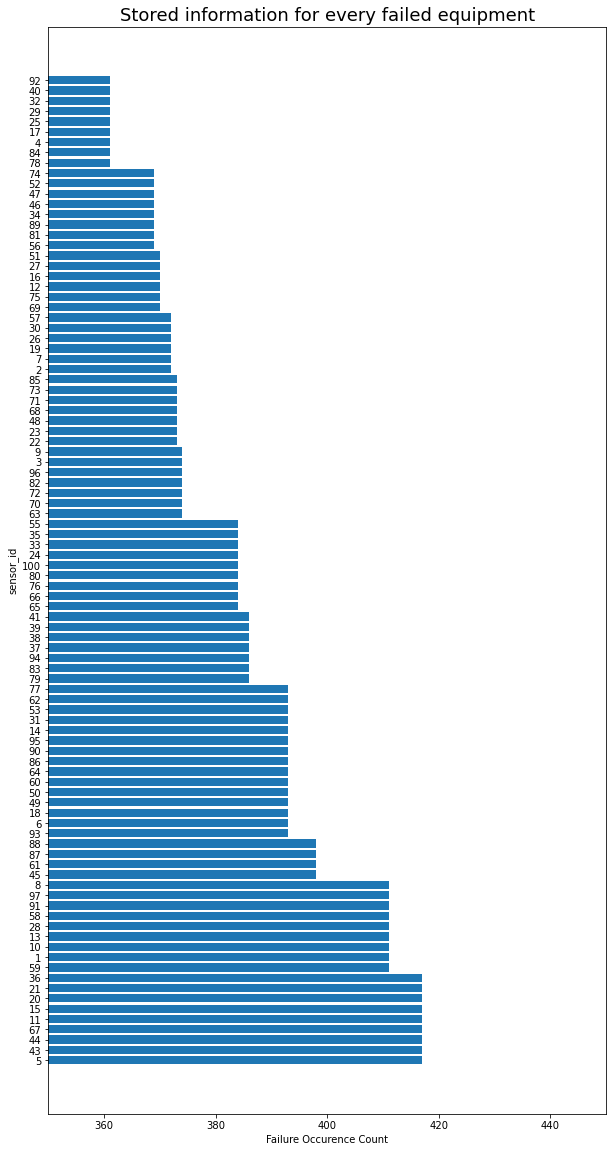

In [15]:
y = df_failure_log_prep["sensor_id"].value_counts()
x = df_failure_log_prep["sensor_id"].unique()
plt.figure(figsize=(10,20))
plt.xlim(350, 450) #adjust chart range
plt.ylabel("sensor_id")
plt.xlabel("Failure Occurence Count")
plt.title("Stored information for every failed equipment",size=18)
plt.barh(x, y)
plt.show()

In [16]:
sorted(df_failure_log_prep["sensor_id"].value_counts().unique())

[361, 369, 370, 372, 373, 374, 384, 386, 393, 398, 411, 417]

#### Total x Activated x Unactivated sensors by id

TOTAL

In [17]:
df_failure_log_prep.nunique()

DATE             101
TIME            4866
sensor_id         96
TEMPERATURE    26160
VIBRATION      36622
dtype: int64

ACTIVATED

In [18]:
df_sensors = pd.read_csv("equipment_sensors.csv",delimiter=";")
df_sensors.nunique()

equipment_id     14
sensor_id       100
dtype: int64

UNACTIVATED

In [19]:
unactivated_sensors = df_sensors["sensor_id"].nunique() - df_failure_log_prep["sensor_id"].nunique()
unactivated_sensors

4

In [20]:
def unactivated_sensors(activated_sensors):
    total_sensorsByID = len(df_sensors["sensor_id"])
    return print("Unactivated Sensors by ID:",sorted(set(range(1, total_sensorsByID)).difference(activated_sensors)))

In [21]:
activated_sensors = df_failure_log_prep["sensor_id"].astype("int").unique()
unactivated_sensors(activated_sensors)

Unactivated Sensors by ID: [42, 54, 98, 99]


#### Amount of "sensors_id" per "equipment_id"

In [22]:
df_sensors["sensor_id"] = df_sensors["sensor_id"].astype("str")
df_sensors.groupby("equipment_id")["sensor_id"].apply(lambda x: "{%s}" % ', '.join(x))

equipment_id
1                           {5, 43, 44, 67}
2          {14, 31, 53, 62, 77, 79, 83, 94}
3     {37, 38, 39, 41, 65, 66, 76, 80, 100}
4               {1, 10, 13, 28, 58, 91, 97}
5       {6, 18, 49, 50, 60, 64, 86, 90, 95}
6              {12, 16, 27, 51, 56, 81, 89}
7                   {8, 45, 61, 87, 88, 93}
8            {2, 7, 19, 26, 30, 57, 69, 75}
9                  {11, 15, 20, 21, 36, 59}
10             {34, 46, 47, 52, 74, 78, 84}
11              {4, 17, 25, 29, 32, 40, 92}
12     {24, 33, 35, 55, 63, 70, 72, 82, 96}
13       {3, 9, 22, 23, 48, 68, 71, 73, 85}
14                         {42, 54, 98, 99}
Name: sensor_id, dtype: object

In [23]:
first_sensorByEquipmentID = df_sensors.groupby("equipment_id")["sensor_id"].first()

#### Created new dataFrame to store "equipment_id" and sum of "FAILURE_OCURRENCE"

In [24]:
df_equipment_failure = pd.DataFrame()
df_equipment_failure["equipment_id"] = sorted(df_sensors["equipment_id"].unique())
df_equipment_failure["FAILURE_OCURRENCE"] = 0

Since there is no "equipment_id" sharing a "sensor_id" with other equipment, the first "sensor_id" of each "equipment_id" will be used as reference to identify the total amount of failures.

In [25]:
print("Amount of failures per sensor_id:")
for i in range(0,len(first_sensorByEquipmentID)):
    
    sensor_occurence_count = df_failure_log_prep.loc[df_failure_log_prep.sensor_id == first_sensorByEquipmentID.iloc[i],
                                                     "sensor_id"].count()
    
    df_equipment_failure["FAILURE_OCURRENCE"][i] = sensor_occurence_count
    
    print("sensor_id",first_sensorByEquipmentID.iloc[i],"=",sensor_occurence_count)

Amount of failures per sensor_id:
sensor_id 5 = 398
sensor_id 14 = 369
sensor_id 37 = 417
sensor_id 1 = 373
sensor_id 6 = 384
sensor_id 12 = 386
sensor_id 8 = 370
sensor_id 2 = 393
sensor_id 11 = 372
sensor_id 34 = 374
sensor_id 4 = 393
sensor_id 24 = 361
sensor_id 3 = 411
sensor_id 42 = 0


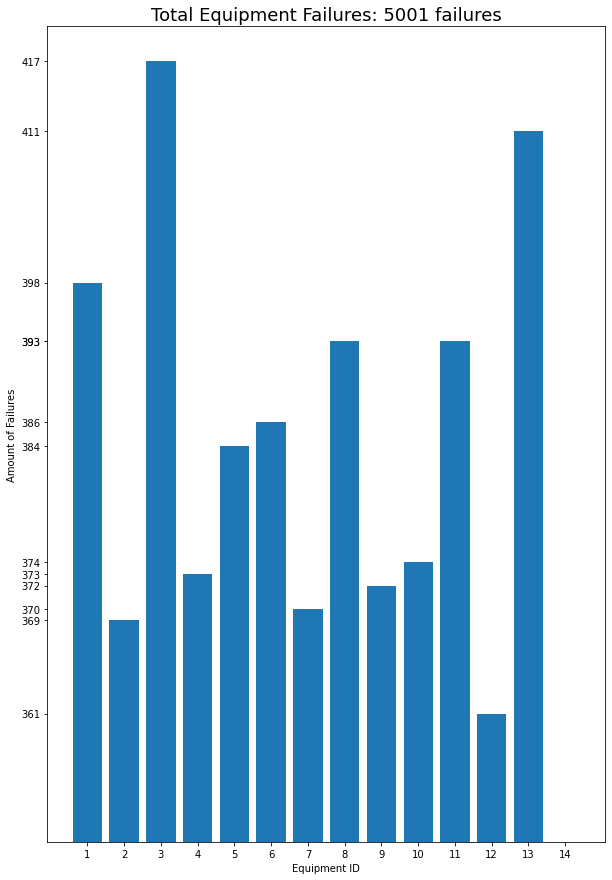

In [26]:
sum_failure = df_equipment_failure["FAILURE_OCURRENCE"].sum()

x = df_equipment_failure["equipment_id"]
height = df_equipment_failure["FAILURE_OCURRENCE"]

plt.figure(figsize=(10,15))

plt.bar(x,height)

plt.ylabel("Amount of Failures")
plt.xlabel("Equipment ID")
plt.title("Total Equipment Failures: " + str(sum_failure) +" failures",size=18)

plt.xticks(df_equipment_failure["equipment_id"])
plt.yticks(df_equipment_failure["FAILURE_OCURRENCE"])

plt.ylim(350, 420) #adjust chart range

plt.show()

<span style="color:blue"><strong>The total of equipment failures is 5001.</strong></span>

# 2. Which equipment code had most failures?

In [27]:
df_equipment = pd.read_json("equipment.json")
df_equipment.nunique()

equipment_id    14
code            14
group_name       6
dtype: int64

In [28]:
df_equipment.dtypes

equipment_id     int64
code            object
group_name      object
dtype: object

In [29]:
left = df_equipment_failure
right = df_equipment
df_equipment_failure = pd.merge(left,right,on="equipment_id")

In [30]:
df_equipment_failure.head()

,equipment_id,FAILURE_OCURRENCE,code,group_name
0,1,398,5310B9D7,FGHQWR2Q
1,2,369,43B81579,VAPQY59S
2,3,417,E1AD07D4,FGHQWR2Q
3,4,373,ADE40E7F,9N127Z5P
4,5,384,78FFAD0C,9N127Z5P


In [31]:
df_equipment_failure[df_equipment_failure["FAILURE_OCURRENCE"]==df_equipment_failure["FAILURE_OCURRENCE"].max()]

,equipment_id,FAILURE_OCURRENCE,code,group_name
2,3,417,E1AD07D4,FGHQWR2Q


<span style="color:blue"><strong>Since we have one "code" for each "equipment_id". "equipment_id" = 3 had most failures, "code" = E1AD07D4 had most failures.</strong></span>

# 3. Average amount of failures across equipment group, ordering by the amount of failures in ascending order?

In [32]:
df_equipment_failure.head()

,equipment_id,FAILURE_OCURRENCE,code,group_name
0,1,398,5310B9D7,FGHQWR2Q
1,2,369,43B81579,VAPQY59S
2,3,417,E1AD07D4,FGHQWR2Q
3,4,373,ADE40E7F,9N127Z5P
4,5,384,78FFAD0C,9N127Z5P


In [33]:
df_equipment_failure.groupby(["group_name", "equipment_id"]).agg({'FAILURE_OCURRENCE': ["sum"]})

FAILURE_OCURRENCE
                                      sum
group_name equipment_id                  
9N127Z5P   4                          373
           5                          384
FGHQWR2Q   1                          398
           3                          417
           7                          370
           12                         361
NQWPA8D3   8                          393
           10                         374
PA92NCXZ   6                          386
           11                         393
VAPQY59S   2                          369
           9                          372
           14                           0
Z9K1SAP4   13                         411

In [34]:
print("Average amount of failures by",df_equipment_failure.groupby(["group_name"])
      ["FAILURE_OCURRENCE"].mean().sort_values(ascending=True))

Average amount of failures by group_name
VAPQY59S    247.0
9N127Z5P    378.5
NQWPA8D3    383.5
FGHQWR2Q    386.5
PA92NCXZ    389.5
Z9K1SAP4    411.0
Name: FAILURE_OCURRENCE, dtype: float64


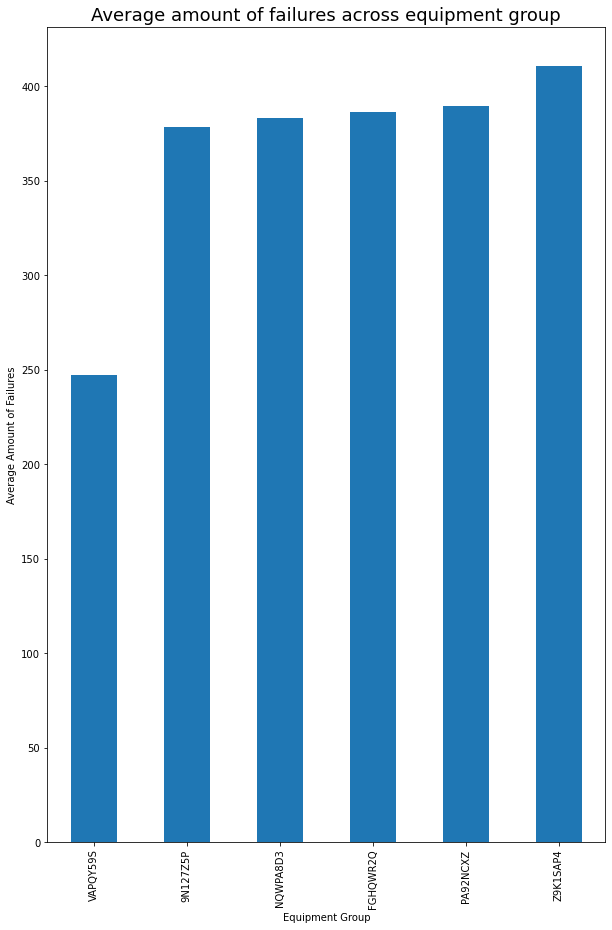

In [35]:
plt.figure(figsize=(10,15))
df_equipment_failure.groupby(["group_name"])["FAILURE_OCURRENCE"].mean().sort_values(ascending=True).plot.bar()

plt.ylabel("Average Amount of Failures")
plt.xlabel("Equipment Group")
plt.title("Average amount of failures across equipment group",size=18)


plt.show()


# Simple data exploration

#### Exploring the "TEMPERATURE" and "VIBRATION" on each "sensor_id"

Min Average Temperature: 231.527913486005
Max Average Temperature: 265.17105527638205


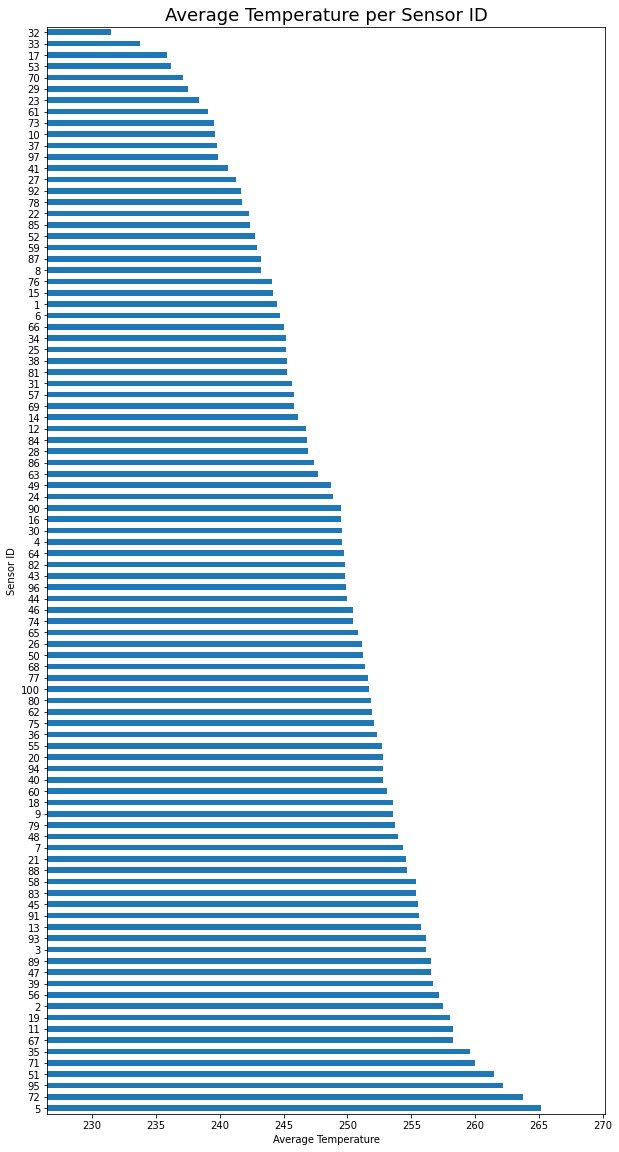

In [36]:
minValue = df_failure_log_prep.groupby("sensor_id")["TEMPERATURE"].mean().min()
maxValue = df_failure_log_prep.groupby("sensor_id")["TEMPERATURE"].mean().max()
print("Min Average Temperature:",minValue)
print("Max Average Temperature:", maxValue)

plt.figure(figsize=(10,20))
plt.xlim(minValue-5, maxValue+5) #adjust chart range
df_failure_log_prep.groupby("sensor_id")["TEMPERATURE"].mean().sort_values(ascending = False).plot.barh()
plt.ylabel("Sensor ID")
plt.xlabel("Average Temperature")
plt.title("Average Temperature per Sensor ID",size=18)


plt.show()

Min Average Vibration: -619.0334139784947
Max Average Vibration: 848.0546354166673


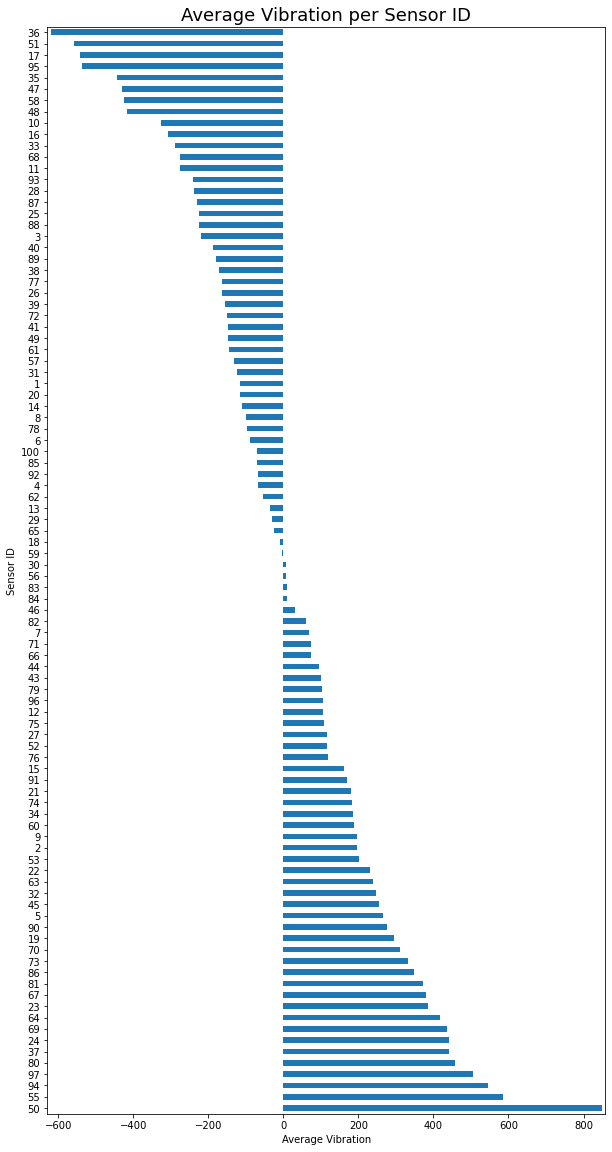

In [37]:
minValue = df_failure_log_prep.groupby("sensor_id")["VIBRATION"].mean().min()
maxValue = df_failure_log_prep.groupby("sensor_id")["VIBRATION"].mean().max()
print("Min Average Vibration:",minValue)
print("Max Average Vibration:", maxValue)

plt.figure(figsize=(10,20))
plt.xlim(minValue-10, maxValue+10) #adjust chart range
df_failure_log_prep.groupby("sensor_id")["VIBRATION"].mean().sort_values(ascending = False).plot.barh()
plt.ylabel("Sensor ID")
plt.xlabel("Average Vibration")
plt.title("Average Vibration per Sensor ID",size=18)


plt.show()

#### Merging all data set into a single dataframe

In [38]:
left = df_equipment_failure
right = df_sensors
df_equipment_failure = pd.merge(left,right,on="equipment_id")

In [39]:
left = df_equipment_failure
right = df_failure_log_prep
df_equipment_failure = pd.merge(left,right,on="sensor_id")

#### "TEMPERATURE" and "VIBRATION" by "equipment_id","group_name" and "DATE"

In [40]:
df_equipment_failure.groupby(["equipment_id","FAILURE_OCURRENCE"])["VIBRATION"].mean().sort_values(ascending = True)

equipment_id  FAILURE_OCURRENCE
11            393                 -124.689455
7             370                 -114.447743
9             372                 -112.444964
4             373                  -66.270758
6             386                  -63.250418
10            374                   -0.295378
13            411                   26.412628
2             369                   50.605180
3             417                   58.164913
12            361                   95.542333
8             393                  101.832646
5             384                  144.261953
1             398                  210.359353
Name: VIBRATION, dtype: float64

In [41]:
df_equipment_failure.groupby(["equipment_id","FAILURE_OCURRENCE"])["TEMPERATURE"].mean().sort_values(ascending = True)

equipment_id  FAILURE_OCURRENCE
11            393                  242.026321
3             417                  247.316843
10            374                  247.702838
4             373                  248.233692
13            411                  248.626018
7             370                  248.640464
2             369                  249.174719
12            361                  249.232819
9             372                  250.827809
5             384                  251.125095
6             386                  251.146688
8             393                  251.787831
1             398                  255.826401
Name: TEMPERATURE, dtype: float64

In [42]:
startPeriod = df_equipment_failure["DATE"].min()
endPeriod = df_equipment_failure["DATE"].max()

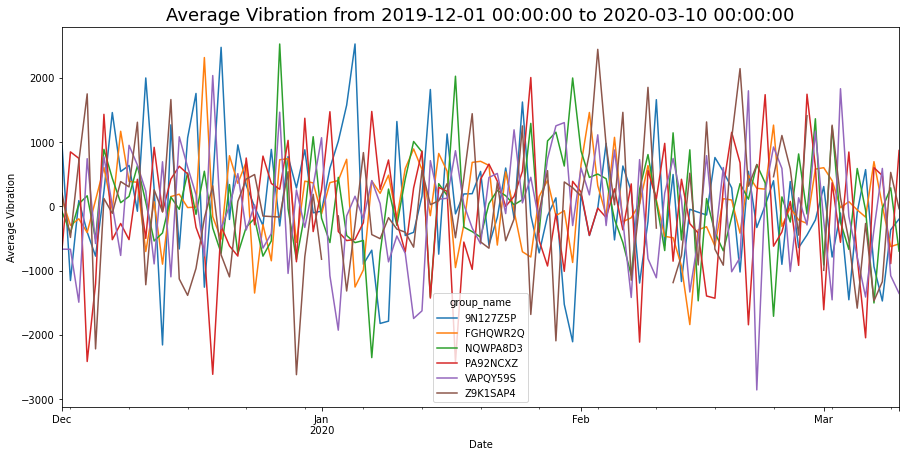

In [43]:
fig, ax = plt.subplots(figsize=(15,7))

df_equipment_failure.groupby(["DATE","group_name"])["VIBRATION"].mean().unstack().plot(ax=ax)
plt.ylabel("Average Vibration")
plt.xlabel("Date")
pltTitle = "Average Vibration from " + str(startPeriod) + " to " + str(endPeriod)
plt.title(pltTitle,size=18)

plt.show()

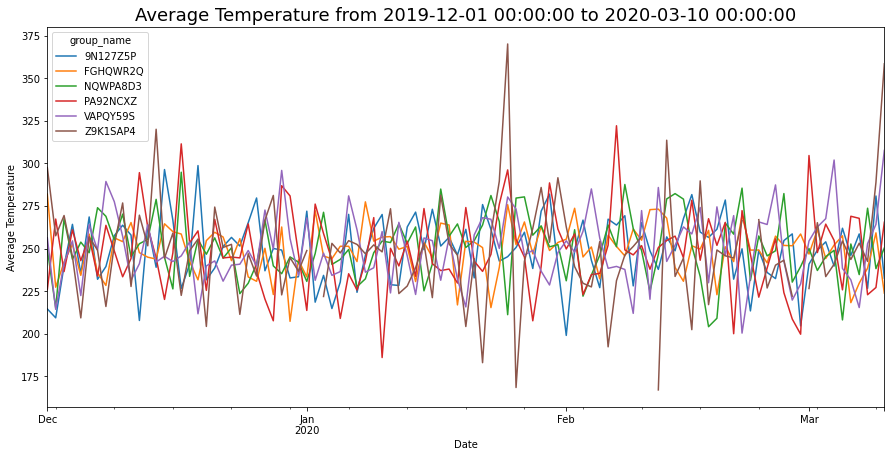

In [44]:
fig, ax = plt.subplots(figsize=(15,7))

df_equipment_failure.groupby(["DATE","group_name"])["TEMPERATURE"].mean().unstack().plot(ax=ax)
plt.ylabel("Average Temperature")
plt.xlabel("Date")
pltTitle = "Average Temperature from " + str(startPeriod) + " to " + str(endPeriod)
plt.title(pltTitle,size=18)

plt.show()

# Conclusion

1.<span style="color:blue"><strong>The total of equipment failures is 5001;</strong></span>

2.<span style="color:blue"><strong>Since we have one "code" for each "equipment_id". "equipment_id" = 3 had most failures, "code" = E1AD07D4 had most failures;</strong></span>

3.<span style="color:blue"><strong>Average amount of failures across equipment group.</strong></span>
<div style="color:blue">
    <ul>
        <li>VAPQY59S    = 247.0</li> 
        <li>9N127Z5P    = 378.5</li>
        <li>NQWPA8D3    = 383.5</li>
        <li>FGHQWR2Q    = 386.5</li>
        <li>PA92NCXZ    = 389.5</li>
        <li>Z9K1SAP4    = 411.0</li>             
    </ul>
</div>

## Additional Comments

<div style="color:blue">
    <ul>
        <li>Further evaluation analysis could better understand the relationship between failure ocurrence, temperature and vibration;</li> 
        <li>Equipment_id = [14] and sensor_id = [42, 54, 98, 99] had not failed during the given period of time;</li>
        <li>Mean, max and min values are provided for the main columns of the data set and could help reducing failure ocurrence;</li>
        <li>Refactoring would make the code more efficient and maintainable;</li>
        <li>Libraries such as Seaborn or a data visualization software like Tableau could provide better statistical graphics and meaning to the data set.</li>            
    </ul>
</div>